In [55]:
import re
from pathlib import Path
import pandas as pd

from ratschlab_common.viz import create_grid, clean_axes_grid
import matplotlib.pyplot as plt

In [4]:
wdir = Path('/cluster/work/grlab/projects/projects2019-supervario/')

In [95]:
path_lut = {
    '10xbreast': wdir/'10x_data_breastcancer/sliceB/processed_files/matrices_homoProp0.5_epsilon0.001_theta0.01/simMat_diff.csv',
    '10xbreast8cell': wdir/'10x_data_breastcancer/sliceB/processed_files/matrices_8cells/simMat_diff.csv',
    'varsim005x': wdir/'hana_varsim_data/matrices_h0.15/simMat_diff.csv',
    'varsim01x': wdir/'hana_varsim_data/matrices_cov0.1/simMat_diff.csv',
    'varsim02x': wdir/'hana_varsim_data/matrices_cov0.2/simMat_diff.csv'
}

data_lut = {
    key: -pd.read_csv(path, header=None).values
    for key, path
    in path_lut.items()
}

In [121]:
def split_hist(ax, data, **kwargs):
    healthy = np.arange(data.shape[0]) < data.shape[0]//2

    ax.hist(data[healthy][:, healthy].ravel(), label='healthy', **kwargs)
    ax.hist(data[~healthy][:, ~healthy].ravel(), label='tumor', **kwargs)
    ax.hist(data[healthy][:, ~healthy].ravel(), label='mismatch', **kwargs)
    return ax

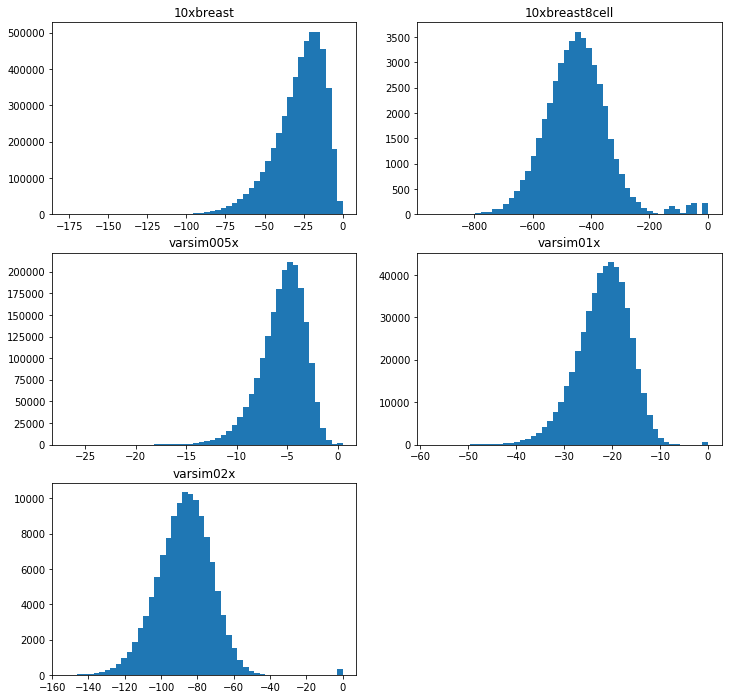

In [96]:
fig, axes = create_grid(len(data_lut), 2)

for ax, (key, data) in zip(axes.ravel(), data_lut.items()):
    ax.hist(data.ravel(), bins=50)
    ax.set_title(key)
clean_axes_grid(axes)

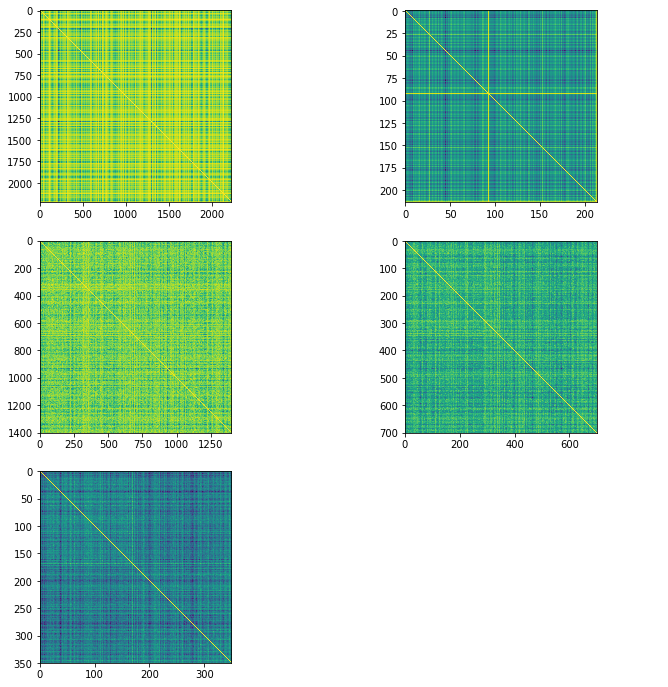

In [97]:
fig, axes = create_grid(len(data_lut), 2)
for ax, (key, data) in zip(axes.ravel(), data_lut.items()):
    data = data.copy()
    ax.imshow(data)
clean_axes_grid(axes)

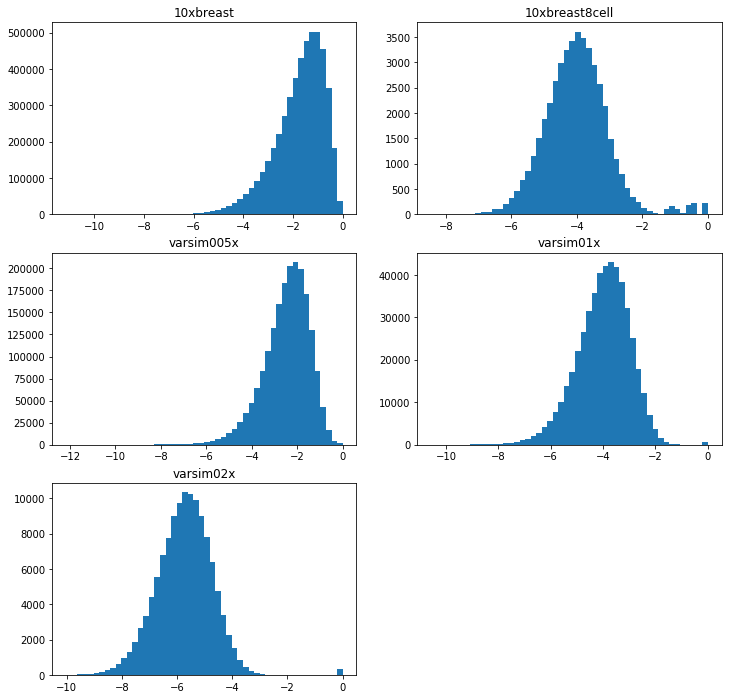

In [98]:
fig, axes = create_grid(len(data_lut), 2)
for ax, (key, data) in zip(axes.ravel(), data_lut.items()):
    data = data.copy()
    data[data > 0] = 0
    ax.hist(data.ravel() / data.std(), bins=50)
    ax.set_title(key)
clean_axes_grid(axes)

In [99]:
preproc_list = ['cut', 'zscore-exp_beta0.5', 'shift']


In [100]:
def preproc(key, data):
    if key == 'cut':
        data[data < 0] = 0
        
    elif key == 'shift':
        data = data - data.min()
    
    elif key.startswith('zscore-exp_beta'):
        beta = float(key.replace('zscore-exp_beta', ''))
        data = zscore(data)
        data = np.exp(beta * data)
    else:
        raise ValueError
    
    return data

In [101]:
import numpy as np
def zscore(data):
    data = data - data.mean()
    data = data / data.std()
    return data

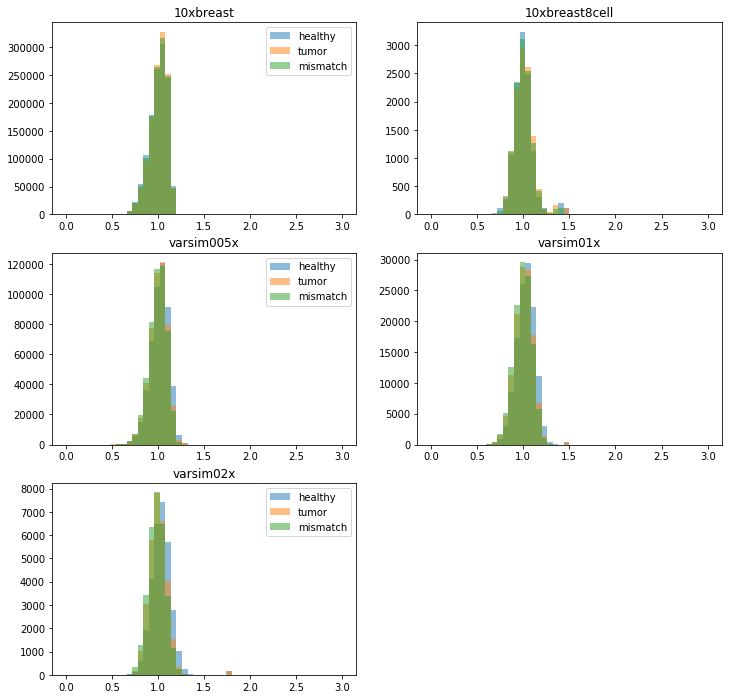

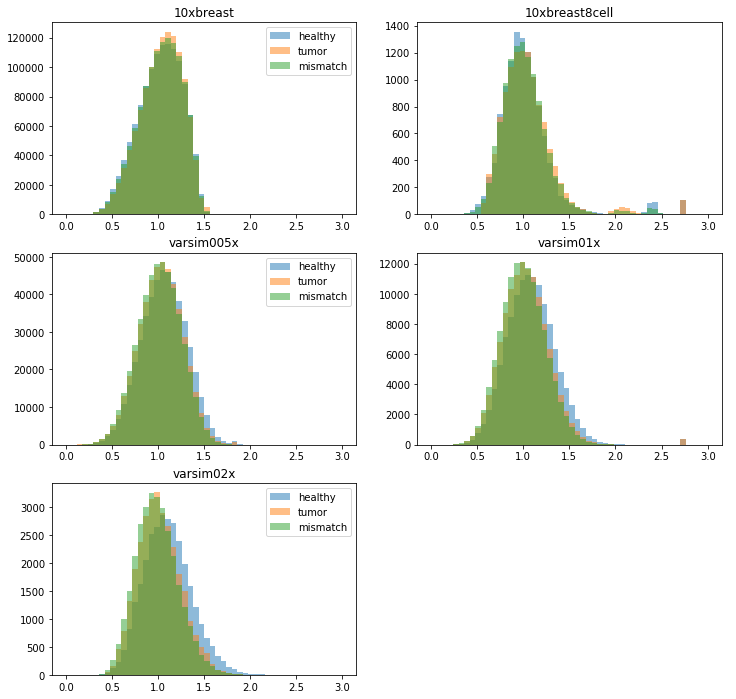

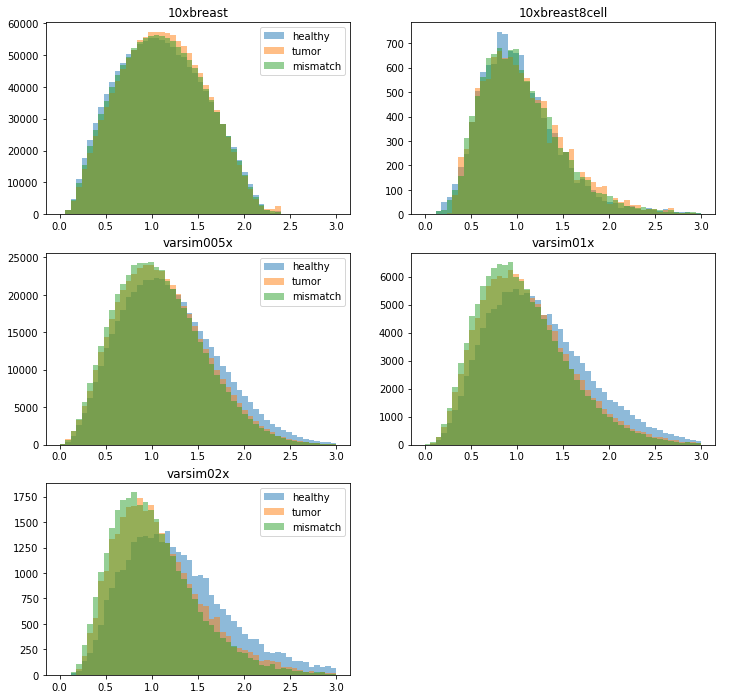

In [127]:
for beta in [0.1, 0.25, 0.5]:
    fig, axes = create_grid(len(data_lut), 2)
    for ax, (key, data) in zip(axes.ravel(), data_lut.items()):
        data = data.copy()
        data = zscore(data)
        data = np.exp(beta * data)
        split_hist(ax, data, bins=50, range=(0,3), alpha=0.5)
        ax.set_title(key)
        if ax in axes[:, 0]:
            ax.legend()
    clean_axes_grid(axes)

In [109]:
labels = dict()
for key, data in data_lut.items():
    for pp in ['zscore-exp_beta0.5', 'zscore-exp_beta0.1', 'zscore-exp_beta0.25']:
        print(key, pp)
        data = preproc(pp, data.copy())
        model = SpectralClustering(2, affinity='precomputed', n_init=100, random_state=15)
        model.fit(data)
        labels[f'{key}-{pp}'] = model.labels_

10xbreast zscore-exp_beta0.5
10xbreast zscore-exp_beta0.1
10xbreast zscore-exp_beta0.25
10xbreast8cell zscore-exp_beta0.5
10xbreast8cell zscore-exp_beta0.1
10xbreast8cell zscore-exp_beta0.25
varsim005x zscore-exp_beta0.5
varsim005x zscore-exp_beta0.1
varsim005x zscore-exp_beta0.25
varsim01x zscore-exp_beta0.5
varsim01x zscore-exp_beta0.1
varsim01x zscore-exp_beta0.25
varsim02x zscore-exp_beta0.5
varsim02x zscore-exp_beta0.1
varsim02x zscore-exp_beta0.25


In [110]:
for key, label in labels.items():
    print(key, label[:label.size//2].mean(), label[label.size//2:].mean())

10xbreast-zscore-exp_beta0.5 0.19874100719424462 0.1735611510791367
10xbreast-zscore-exp_beta0.1 0.28776978417266186 0.2526978417266187
10xbreast-zscore-exp_beta0.25 0.2976618705035971 0.2670863309352518
10xbreast8cell-zscore-exp_beta0.5 0.12149532710280374 0.16822429906542055
10xbreast8cell-zscore-exp_beta0.1 0.4766355140186916 0.45794392523364486
10xbreast8cell-zscore-exp_beta0.25 0.5327102803738317 0.5327102803738317
varsim005x-zscore-exp_beta0.5 0.4185714285714286 0.46714285714285714
varsim005x-zscore-exp_beta0.1 0.4357142857142857 0.45
varsim005x-zscore-exp_beta0.25 0.4442857142857143 0.44285714285714284
varsim01x-zscore-exp_beta0.5 0.014285714285714285 0.9885714285714285
varsim01x-zscore-exp_beta0.1 0.9885714285714285 0.0
varsim01x-zscore-exp_beta0.25 0.9428571428571428 0.0
varsim02x-zscore-exp_beta0.5 1.0 0.0
varsim02x-zscore-exp_beta0.1 0.9714285714285714 0.0
varsim02x-zscore-exp_beta0.25 0.9142857142857143 0.0
